## Subduction Zone Kinematics: 2016 Update

This notebook illustrates plotting of the output data lookup table from the updated subduction zone kinematics pygplates method, using the Müller et al AREPS model:

- Data are precomputed and stored in a hdf5 file, and loaded into a pandas data table for manipulation

- implemented to work directly on the plate model gpml files (whereas before, you had to export the resolved topologies at 1Myr increments first)
- this notebook also interpolates the age of the subducting plate age from age grids if provided
- update 2016/07/25 to determine subduction type (intra-oceanic versus ocean-continent) by looking at nearest static polygon to each point

In [1]:
import pygplates
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap
from topology_plotting import *
from matplotlib.patches import Polygon
import pandas as pd

%matplotlib inline

#######################################################
# Define Input files for Muller 2016 AREPS model
#######################################################
rotation_filename = ['/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/Global_EB_250-0Ma_GK07_Matthews_etal.rot',\
                     '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/Global_EB_410-250Ma_GK07_Matthews_etal.rot']

# input topologies to be used with the subduction_convergence script
input_topology_filename = ['/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_Matthews_etal.gpml',\
                           '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/TopologyBuildingBlocks_AREPS.gpml',\
                           '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/Global_EarthByte_Paleozoic_plate_boundaries_Matthews_etal.gpml']

# Static polygons to determine whether subduction segment is adjacent to continent or not
static_polygon_filename = '../Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.gpmlz'
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
continental_polygon_features = []
for feature in static_polygon_features:
    if feature.get_feature_type() == pygplates.FeatureType.gpml_closed_continental_boundary:
        continental_polygon_features.append(feature)


######################################################
rotation_model = pygplates.RotationModel(rotation_filename)

# specify time range and resolution for plots
threshold_sampling_distance_radians = np.radians(0.5)

# Define the time snapshots at which to get the subduction zone properties
min_time = 0.
max_time = 410.
time_step = 5.

# Set the delta time for velocity calculations
velocity_delta_time = 5.

# Typically the achor plate id should be 0
anchor_plate_id = 0

# Example of loading previously calculated results from a hdf5 file as created using the line above
df = pd.read_csv('SubductionTable_0_410Ma.csv')

mr = np.asarray(df['migr_rate'])
mo = np.asarray(df['migr_obliq'])

cr = np.asarray(df['conv_rate'])
co = np.asarray(df['conv_obliq'])

# NOTE
# the absolute velocity magnitude is negative if the subduction zone (trench)
# is moving towards the overriding plate (if absolute motion obliquity angle is less than 90 or greater than -90)
# So, to get the orthogonal migration, we actually ignore the sign of the migration rate, since the obliquity
# angle also distinguishes between trench advance and retreat (full range is -180 to +180)
df['ortho_migr_rate'] = pd.Series(np.abs(mr)*-np.cos(np.radians(mo)), index=df.index)

df['ortho_conv_rate'] = pd.Series(cr*np.abs(np.cos(np.radians(co))), index=df.index)

df_AllTimes = df

#print np.sin(np.radians(np.abs(mo)[0:10]))*mr[0:10]
#print df_AllTimes['ortho_migr_rate']
# Display the contents of the table containing all subduction
df

/Users/Simon/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


,Unnamed: 0,lon,lat,conv_rate,conv_obliq,migr_rate,migr_obliq,arc_length,arc_azimuth,subducting_plate,overriding_plate,time,ortho_migr_rate,ortho_conv_rate
0,0,-179.937442,50.444919,6.788645,-54.791529,1.238718,165.042828,0.407674,7.048196,901.0,101.0,0.0,1.196749,3.914014
1,1,-179.904160,-37.283931,4.737098,-37.884973,-5.016294,44.471417,0.468018,293.688940,901.0,801.0,0.0,-3.579627,3.738732
2,2,-179.705383,-11.225768,9.121439,66.433666,11.398003,-134.339499,0.338897,196.384032,901.0,801.0,0.0,7.966161,3.646847
3,3,-179.669162,-36.855115,4.809607,-37.215929,-4.978664,44.898118,0.468018,293.547286,901.0,801.0,0.0,-3.526701,3.830187
4,4,-179.436788,-36.425842,4.882546,-36.568630,-4.941149,45.333236,0.468018,293.408606,901.0,801.0,0.0,-3.473540,3.921387
5,5,-179.373795,-11.321178,9.102462,66.709036,11.255728,-133.593382,0.338897,196.319209,901.0,801.0,0.0,7.761228,3.599119
6,6,-179.302793,50.393168,6.771240,-55.000783,1.253954,165.228730,0.407674,7.537337,901.0,101.0,0.0,1.212513,3.883748
7,7,-179.206970,-35.996123,4.955878,-35.942239,-4.903761,45.776925,0.468018,293.272837,901.0,801.0,0.0,-3.420147,4.012324
8,8,-179.041987,-11.416219,9.083647,66.986281,11.115225,-132.827267,0.338897,196.253802,901.0,801.0,0.0,7.556024,3.551266
9,9,-179.005424,-35.546225,5.034158,-29.044780,-4.867971,52.591419,0.490832,286.827791,901.0,801.0,0.0,-2.957267,4.401065


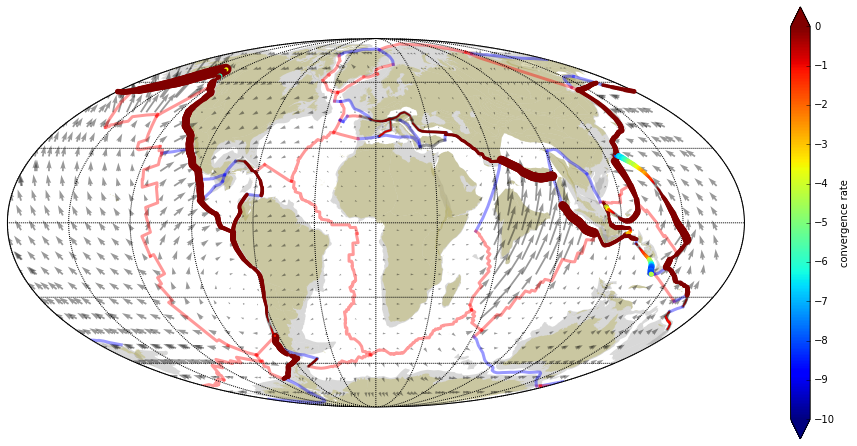

In [30]:
# Vary this time to see a different reconstruction time. Must be integer between 0 and 200 
time = 50

subset = df_AllTimes[(df_AllTimes['time']==time)]

coastlines_file = '../Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time)

pygplates.reconstruct(continental_polygon_features, rotation_model, 'tmp2.shp', time)

fig = plt.figure(figsize=(16,6),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])
lon0=0
m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
#m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
cp = m.drawmapboundary()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

# Plot reconstructed coastlines
shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
for nshape,seg in enumerate(m.shp):
    poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0.5)
    plt.gca().add_patch(poly)

# Plot reconstructed coastlines
shp_info = m.readshapefile('tmp2','shp',drawbounds=True,color='none')
for nshape,seg in enumerate(m.shp):
    poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.3,zorder=0.25)
    plt.gca().add_patch(poly)

plot_velocities_and_topologies(m,input_topology_filename,rotation_model,time,
                               delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)

x, y = m(np.asarray(subset.lon), np.asarray(subset.lat))
l1 = m.scatter(x,y,c=np.asarray(subset.ortho_conv_rate),s=np.abs(subset.ortho_conv_rate)*5,edgecolor='',zorder=5,vmin=-10,vmax=0)

#plt.title('Distance From subduction segments to nearest continental block at %s Ma' % time, size=16)

plt.colorbar(l1,extend='both',label='convergence rate')

plt.show()

/Users/Simon/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


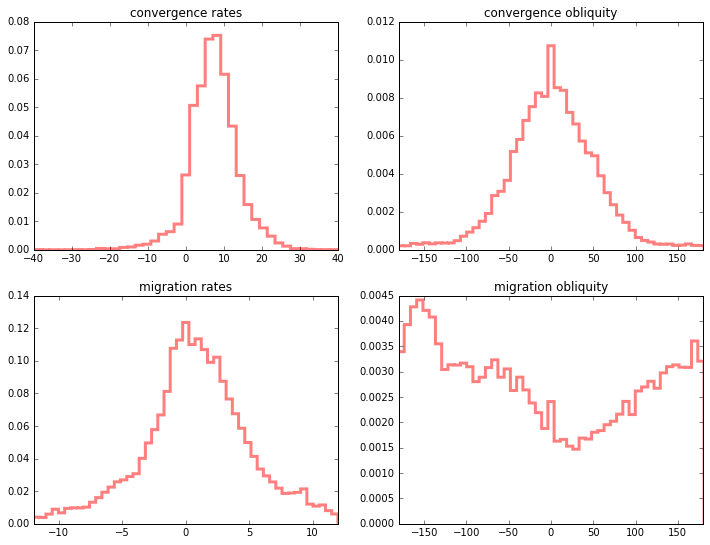

In [6]:
# This threshold controls how we divide between 'Intra-Oceanic' and 'Ocean-Continent' subduction segments.
# It is basically a distance threshold, based on the computed distance of each point to the nearest
# polygon in the static polygon file that is labelled as 'continental_closed_polygon'
threshold = 200

plt.figure(figsize=(12,9))

plt.subplot(221)
bins = np.linspace(-50,50,50)
l1 = plt.hist(df['conv_rate'],bins=bins,alpha=0.5,color='r',
              normed=1,histtype = 'step',linewidth=3)
plt.xlim(-40,40)
plt.title('convergence rates')
plt.legend(loc='upper left')

plt.subplot(222)
bins = np.linspace(-181,181,50)
plt.hist(df['conv_obliq'],bins=bins,alpha=0.5,color='r',
         normed=1,histtype='step',linewidth=3)
plt.xlim(-180,180)
plt.title('convergence obliquity')
#plt.legend()

plt.subplot(223)
bins = np.linspace(-12,12,50)
plt.hist(df['ortho_migr_rate'],bins=bins,alpha=0.5,color='r',
         normed=1,histtype='step',linewidth=3)
plt.xlim(-12,12)
plt.title('migration rates')
#plt.legend()

plt.subplot(224)
bins = np.linspace(-181,181,50)
plt.hist(df['migr_obliq'],bins=bins,alpha=0.5,color='r',
         normed=1,histtype='step',linewidth=3)
plt.xlim(-180,180)
plt.title('migration obliquity')
#plt.legend()

plt.show()



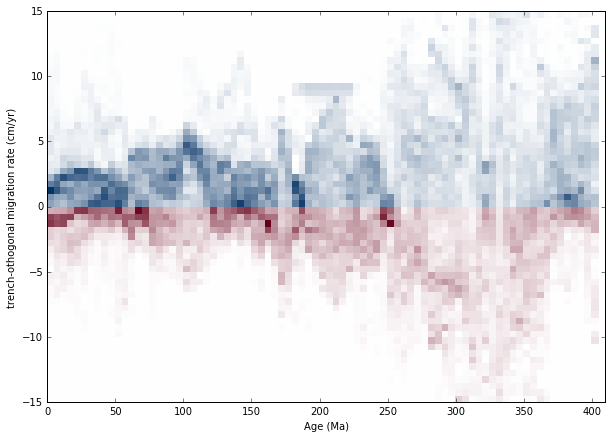

In [14]:
from mpltools import color
# Set Colorbar
bcr_rgba = [(0.4, 0.0, 0.1, 1),
                (1.0, 1.0, 1.0, 1),
                (1.0, 1.0, 1.0, 1),
            (0.02,  0.2, 0.4, 1)]
blue_clear_red = color.LinearColormap('blue_clear_red', bcr_rgba,
                                      index=[0, 0.5, 0.5, 1])

MinTime = 0
MaxTime = 410 
TimeStep = 5
VMIN = -15
VMAX = 15

plt.figure(figsize=(10,7))

def MakeTimeDependentHistogram(df_tmp):

    TimeStepList = np.arange(MinTime,MaxTime,TimeStep)
    VelBins = np.arange(-15,15.5,0.5)
    histCat = np.zeros((len(TimeStepList),len(VelBins)-1))
    count = 0
    for TIME in TimeStepList:
        subset = df_tmp[(df_tmp['time']>=TIME) & (df_tmp['time']<(TIME+TimeStep))]
        
        tmp = np.histogram(subset['ortho_migr_rate'],bins=VelBins)
        histCat[count,:] = 100*np.double(tmp[0].T)/np.asarray(subset['ortho_migr_rate']).shape[0]
        count=count+1

    histCat[:,0:len(VelBins)/2] = histCat[:,0:len(VelBins)/2]*-1

    plt.pcolor(TimeStepList, VelBins, histCat.T,cmap=blue_clear_red,vmin=VMIN,vmax=VMAX)
    plt.gca().set_xlim([MinTime,MaxTime])
    plt.ylabel('trench-othogonal migration rate (cm/yr)')
    plt.xlabel('Age (Ma)')

MakeTimeDependentHistogram(df)

plt.show()


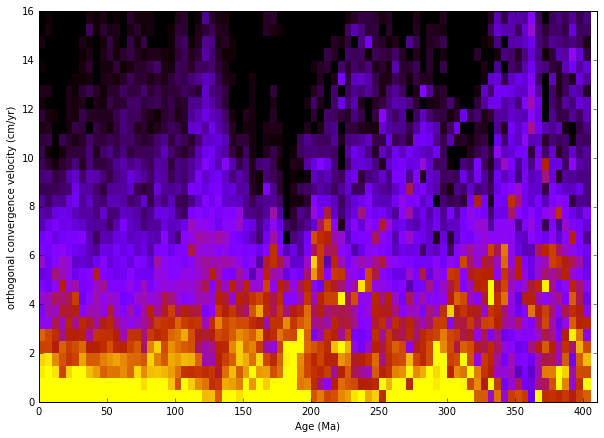

In [16]:
from mpltools import color
# Set Colorbar
bcr_rgba = [(0.4, 0.0, 0.1, 1),
                (1.0, 1.0, 1.0, 1),
                (1.0, 1.0, 1.0, 1),
            (0.02,  0.2, 0.4, 1)]
blue_clear_red = color.LinearColormap('blue_clear_red', bcr_rgba,
                                      index=[0, 0.5, 0.5, 1])

MinTime = 0
MaxTime = 410
TimeStep = 5
VMIN = 0
VMAX = 10

plt.figure(figsize=(10,7))

def MakeTimeDependentHistogram(df_tmp):
    
    TimeStepList = np.arange(MinTime,MaxTime,TimeStep)
    VelBins = np.arange(0,16.5,.5)
    histCat = np.zeros((len(TimeStepList),len(VelBins)-1))
    count = 0
    for TIME in TimeStepList:
        subset = df_tmp[(df_tmp['time']>=TIME) & (df_tmp['time']<(TIME+TimeStep))]
        cr = np.asarray(subset['conv_rate'])
        co = np.asarray(subset['conv_obliq'])
        ocr = cr*np.sin(np.radians(np.abs(co)))
        tmp = np.histogram(ocr,bins=VelBins)
        histCat[count,:] = 100*np.double(tmp[0].T)/ocr.shape[0]
        count=count+1

    plt.pcolor(TimeStepList, VelBins, histCat.T,cmap=plt.cm.gnuplot,vmin=VMIN,vmax=VMAX)
    plt.gca().set_xlim([MinTime,MaxTime])
    plt.ylabel('orthogonal convergence velocity (cm/yr)')
    plt.xlabel('Age (Ma)')


MakeTimeDependentHistogram(df)

plt.show()



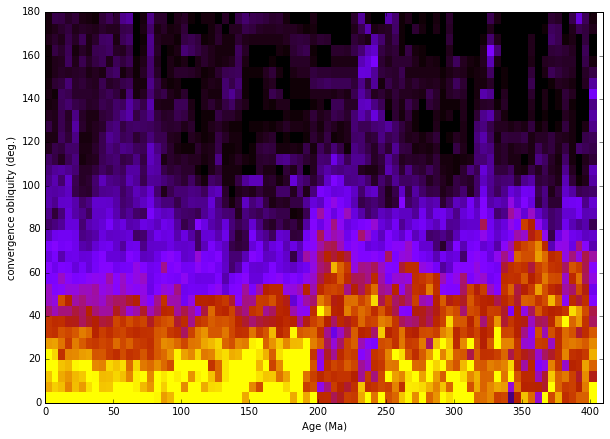

In [17]:
from mpltools import color
# Set Colorbar
bcr_rgba = [(0.4, 0.0, 0.1, 1),
                (1.0, 1.0, 1.0, 1),
                (1.0, 1.0, 1.0, 1),
            (0.02,  0.2, 0.4, 1)]
blue_clear_red = color.LinearColormap('blue_clear_red', bcr_rgba,
                                      index=[0, 0.5, 0.5, 1])

MinTime = 0
MaxTime = 410
TimeStep = 5
VMIN = 0
VMAX = 10

plt.figure(figsize=(10,7))

def MakeTimeDependentHistogram(df_tmp):
    
    TimeStepList = np.arange(MinTime,MaxTime,TimeStep)
    VelBins = np.arange(0,185,5)
    histCat = np.zeros((len(TimeStepList),len(VelBins)-1))
    count = 0
    for TIME in TimeStepList:
        subset = df_tmp[(df_tmp['time']>=TIME) & (df_tmp['time']<(TIME+TimeStep))]
        tmp = np.histogram(np.abs(subset['conv_obliq']),bins=VelBins)
        histCat[count,:] = 100*np.double(tmp[0].T)/np.asarray(subset['conv_obliq']).shape[0]
        count=count+1

    plt.pcolor(TimeStepList, VelBins, histCat.T,cmap=plt.cm.gnuplot,vmin=VMIN,vmax=VMAX)
    plt.gca().set_xlim([MinTime,MaxTime])
    plt.ylabel('convergence obliquity (deg.)')
    plt.xlabel('Age (Ma)')
    
MakeTimeDependentHistogram(df)

plt.show()





In [18]:
for time in np.arange(0,200,5):
    
    subset = df_AllTimes[(df_AllTimes['time']==time)]
    
    coastlines_file = '../Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
    pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time)

    pygplates.reconstruct(continental_polygon_features, rotation_model, 'tmp2.shp', time)
    
    fig = plt.figure(figsize=(14,10),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0.5)
        plt.gca().add_patch(poly)
        
    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp2','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.3,zorder=0.25)
        plt.gca().add_patch(poly)

    plot_velocities_and_topologies(m,input_topology_filename,rotation_model,time,
                                   delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)

    x, y = m(np.asarray(subset.lon), np.asarray(subset.lat))
    l1 = m.scatter(x,y,c=np.asarray(subset.ortho_conv_rate),s=40,edgecolor='',zorder=5,vmin=-10,vmax=0)
    
    plt.title('Convergence Rate at %s Ma' % time, size=16)
    plt.colorbar(l1,extend='max',label='distance (km)')

    plt.savefig('ortho_conv%s.png' % time)
    plt.close()
    